<a href="https://colab.research.google.com/github/ZackAkil/One-shot-multi-object-detection-for-sports/blob/main/One_shot_multi_object_detection_(for_sports).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# One shot multi object detection (for sports)


---

Experiment to see if you can apply heuristic techniques combined with pre-trained models to quickly predict multiple similare object within a single image. To be applied to finding multiple players on a playing field.

If it is succesul this can be usful in assisten labeling tasks that can then be used in training mor efficient models.


## Load video


In [2]:
!wget https://storage.googleapis.com/rugby-app-videos/LOTGTvYPM2/clips/LOTGTvYPM2_1557_1572.mp4

--2022-07-03 21:31:36--  https://storage.googleapis.com/rugby-app-videos/LOTGTvYPM2/clips/LOTGTvYPM2_1557_1572.mp4
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.63.128, 172.217.15.112, 172.217.12.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.63.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3852230 (3.7M) [video/mp4]
Saving to: ‘LOTGTvYPM2_1557_1572.mp4’

LOTGTvYPM2_1557_157 100%[===================>]   3.67M  --.-KB/s    in 0.05s   

2022-07-03 21:31:36 (75.3 MB/s) - ‘LOTGTvYPM2_1557_1572.mp4’ saved [3852230/3852230]



# Get image from video

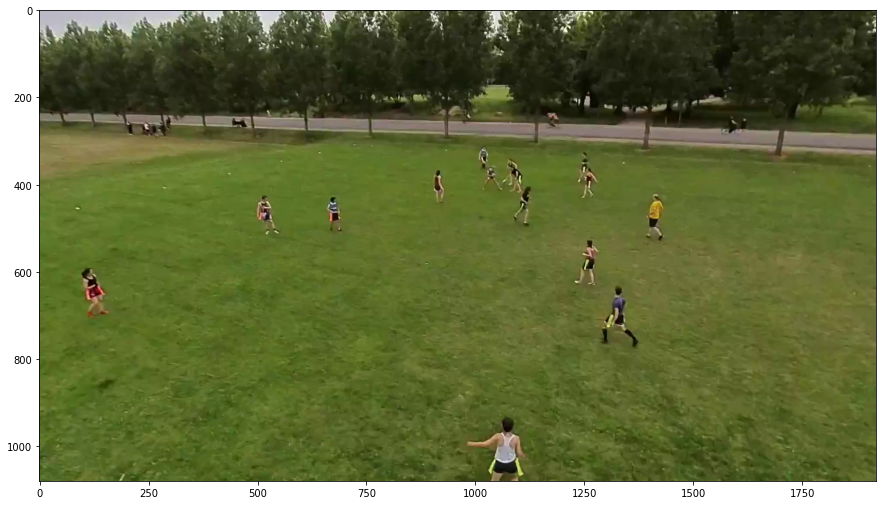

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

video_source = "LOTGTvYPM2_1557_1572.mp4"

cap = cv2.VideoCapture(video_source)

_, frame1 = cap.read()
RGB_img = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)

plt.figure(figsize = (15, 15))
plt.imshow(RGB_img)
plt.show()

# Get single player

(91, 52, 3)


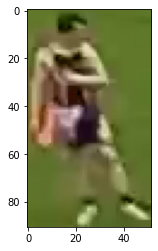

In [4]:
player = RGB_img[424:515, 499:551]
plt.imshow(player)
print(player.shape)
plt.show()

# Load pre-trained image vectoriser

In [5]:
import tensorflow as tf
import tensorflow_hub as hub

model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_035_224/feature_vector/5",
                   trainable=False),  # Can be True, see below.
])
model.build([None, 224, 224, 3])  # Batch input shape.

# Feed player image into vectoriser

(224, 224, 3)


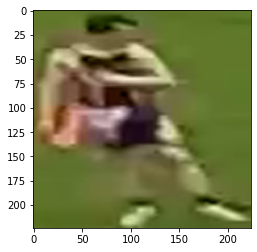

In [6]:
scaled_image = cv2.resize(player, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
plt.imshow(scaled_image)
print(scaled_image.shape)
plt.show()

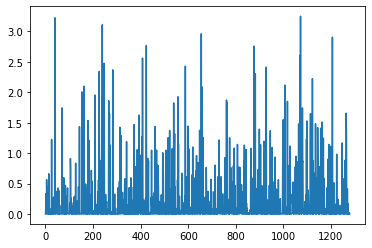

In [25]:
player_vector = model.predict(np.expand_dims(scaled_image, axis=0))
plt.plot(player_vector[0,:])
plt.show()

# Compare vectors of examples of similare and not similair parts of image

(81, 36, 3)


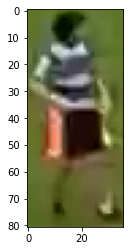

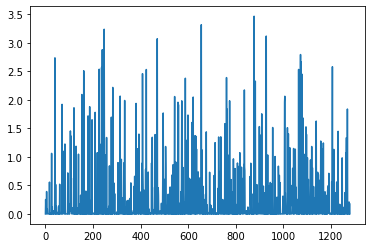

0.7720628976821899
(81, 36, 3)


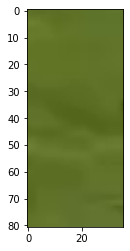

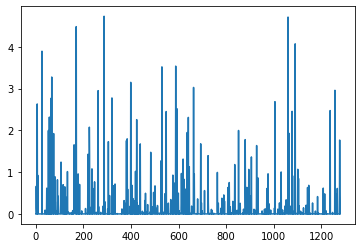

0.2563994526863098


In [26]:
from scipy import spatial

# similare
similare_to_player = RGB_img[428:509, 659:695]
plt.imshow(similare_to_player)
print(similare_to_player.shape)
plt.show()

scaled_similare_to_player = cv2.resize(similare_to_player, dsize=(224, 224), 
                                       interpolation=cv2.INTER_CUBIC)
similare_vector = model.predict(np.expand_dims(scaled_similare_to_player, axis=0))
plt.plot(similare_vector[0,:])
plt.show()

similare_distance = 1 - spatial.distance.cosine(similare_vector, player_vector)
print(similare_distance)


# not similare
not_similare_to_player = RGB_img[558:639, 659:695]
plt.imshow(not_similare_to_player)
print(not_similare_to_player.shape)
plt.show()

scaled_not_similare_to_player = cv2.resize(not_similare_to_player, dsize=(224, 224), 
                                       interpolation=cv2.INTER_CUBIC)
not_similare_vector = model.predict(np.expand_dims(scaled_not_similare_to_player, axis=0))
plt.plot(not_similare_vector[0,:])
plt.show()

not_similare_distance = 1 - spatial.distance.cosine(not_similare_vector, player_vector)
print(not_similare_distance)

# Make sliding window to run logic across whole image (convolution)

In [28]:
# helper function

def get_image_similarity(original_vector, new_image):
  # scale image
  scaled_image = cv2.resize(new_image, dsize=(224, 224), 
                            interpolation=cv2.INTER_CUBIC)
  # vectorise image
  image_vector = model.predict(np.expand_dims(scaled_image, axis=0))

  # get similarity mesurment
  distance = 1 - spatial.distance.cosine(image_vector, original_vector)

  return distance

get_image_similarity(player_vector, similare_to_player)

0.7720628976821899

In [64]:
# window config

# window_height = 91
# window_width = 52

window_height = 100
window_width = 70
stride = 25

In [65]:
RGB_img.shape

(1080, 1920, 3)

width from 100 to 170, height from 575 to 675


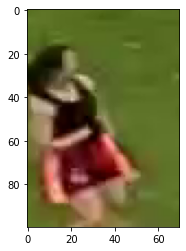

width from 225 to 295, height from 75 to 175


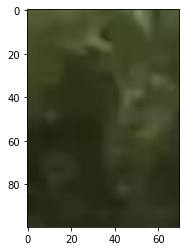

width from 325 to 395, height from 675 to 775


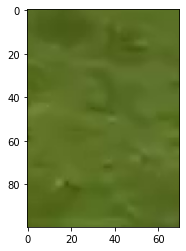

width from 450 to 520, height from 175 to 275


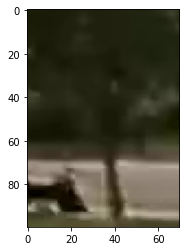

width from 550 to 620, height from 775 to 875


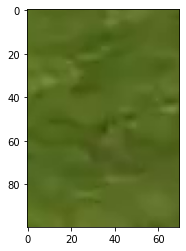

width from 675 to 745, height from 275 to 375


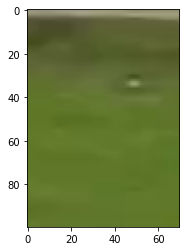

width from 775 to 845, height from 875 to 975


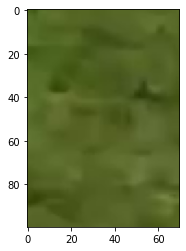

width from 900 to 970, height from 375 to 475


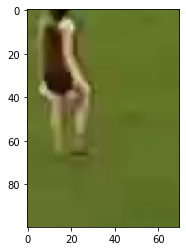

width from 1000 to 1070, height from 975 to 1075


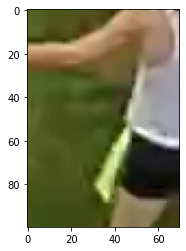

width from 1125 to 1195, height from 475 to 575


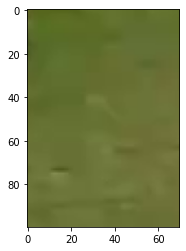

width from 1225 to 1295, height from 1075 to 1175


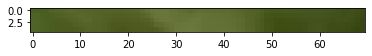

width from 1350 to 1420, height from 575 to 675


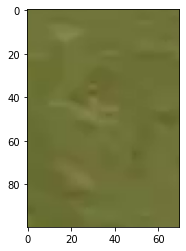

width from 1475 to 1545, height from 75 to 175


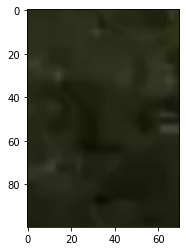

width from 1575 to 1645, height from 675 to 775


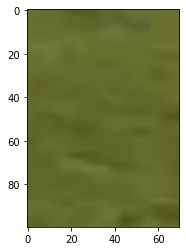

width from 1700 to 1770, height from 175 to 275


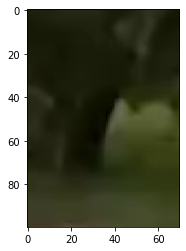

width from 1800 to 1870, height from 775 to 875


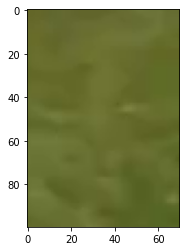

In [66]:
count = 0

output = np.zeros([int(1080/stride)+1, int(1920/stride)+1])

for w in range(0, 1920, stride):
  for h in range(0, 1080, stride):
    count += 1
    frame = RGB_img[h:h+window_height, w:w+window_width]
    similarity_score = get_image_similarity(player_vector, frame)
    output[int(h/stride), int(w/stride)] = similarity_score
    if not (count % 200):
      print(f'width from {w} to {w+window_width}, height from {h} to {h+window_height}')
      plt.imshow(frame)
      plt.show()


# Show similarity map

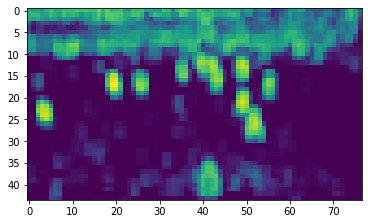

In [67]:
plt.imshow(output)
plt.show()

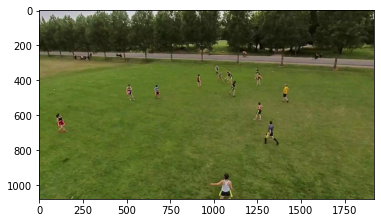

In [75]:
plt.imshow(RGB_img)
plt.show()

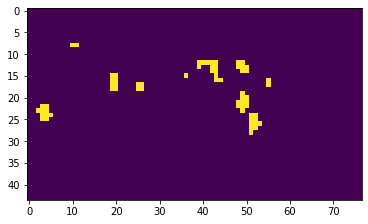

In [76]:
# with an adjusted threshold 

plt.imshow(output>0.76)
plt.show()

# Conclusion
With a single bounding box labeled we were able to find areas of similairly sized objects within the rest of an image. 

A system that then let you interactivly select these "discovered" obejct and add them to an instance based model to future enhance the model in realtime would be an incredibly satisfying devloper experience for quickly building new models. **Like a clay molding experience**.